## Model variables and dynamics (summary)

We consider a **2D Boussinesq atmosphere** in an $x$–$z$ plane.

---

### Domain and coordinates
$$
x \in [0,L_x], \quad z \in [0,L_z]
$$
- $x$: horizontal direction (periodic)  
- $z$: vertical direction (rigid top and bottom)

---

### Prognostic variables
$$
u(x,z,t) \quad \text{horizontal velocity (m s}^{-1}\text{)}
$$
$$
w(x,z,t) \quad \text{vertical velocity (m s}^{-1}\text{)}
$$
$$
\theta(x,z,t) \quad \text{potential temperature (K)}
$$

---

### Reference state
A statically stable background stratification:
$$
\theta_0(z) = \theta_{\text{ref}} + \frac{d\theta_0}{dz}\,z
$$

Perturbation:
$$
\theta'(x,z,t) = \theta(x,z,t) - \theta_0(z)
$$

---

### Governing equations (Boussinesq, non-rotating)

**Momentum (advection + buoyancy + diffusion):**
$$
\frac{\partial u}{\partial t}
+ u\frac{\partial u}{\partial x}
+ w\frac{\partial u}{\partial z}
= \nu \nabla^2 u
$$

$$
\frac{\partial w}{\partial t}
+ u\frac{\partial w}{\partial x}
+ w\frac{\partial w}{\partial z}
= \frac{g}{\theta_{\text{ref}}}\,\theta'
+ \nu \nabla^2 w
$$

**Thermodynamics (passive potential temperature):**
$$
\frac{\partial \theta}{\partial t}
+ u\frac{\partial \theta}{\partial x}
+ w\frac{\partial \theta}{\partial z}
= \kappa \nabla^2 \theta
$$

---

### Incompressibility (Boussinesq constraint)
$$
\frac{\partial u}{\partial x} + \frac{\partial w}{\partial z} = 0
$$

This is enforced numerically by a **pressure projection step**.

---

### Numerical details
- Spatial derivatives: second-order central finite differences  
- Time stepping: explicit Runge–Kutta (RK2 / RK4 variants)  
- Horizontal boundary: periodic  
- Vertical boundary: $w=0$ at $z=0,L_z$  
- Diffusion coefficients:
  - $\nu$: momentum diffusion (viscosity)
  - $\kappa$: thermal diffusion

---

### Physical interpretation
- Stable stratification supports **gravity waves**
- A near-surface cold anomaly acts as a **density current**
- Without rotation, frontal gradients **adjust and decay**
- Vertical motion is weak and transient (cm–dm s$^{-1}$)

---

### Model regime
This setup represents:
- ✔ gravity waves  
- ✔ density currents / cold pools  
- ❌ true synoptic fronts (require rotation & baroclinicity)

---


In [12]:
import numpy as np

# ============================================================
# Cold-front-like IC (2D density current / cold pool)
# ============================================================

# Domain (make x big enough to look synoptic-ish)
Lx_km = 2000.0
Lz_km = 20.0
nx = 200
nz = 40

x = np.linspace(0, Lx_km * 1e3, nx, endpoint=False)  # periodic
z = np.linspace(0, Lz_km * 1e3, nz)
X, Z = np.meshgrid(x, z, indexing="xy")

dx = (Lx_km * 1e3) / nx
dz = (Lz_km * 1e3) / (nz - 1)

# Background stable stratification
theta_ref = 300.0
dtheta_dz = 3e-3  # K/m  (stable)
theta0_1d = theta_ref + dtheta_dz * z
theta0 = theta0_1d[:, None] * np.ones((1, nx))

# Cold pool / "cold front" wedge near the surface, left side
# -8 K in lowest ~2 km, smoothed in x and z
cold_amp = -2.0          # K
z_cold = 1500.0          # m depth
x_front = 400e3          # m: initial front position
x_width = 150e3           # m: smoothing width

mask_z = 0.5 * (1.0 + np.tanh((z_cold - Z) / 300.0))          # 1 below ~2km
mask_x = 0.5 * (1.0 - np.tanh((X - x_front) / x_width))      # 1 left of front

theta = theta0 + cold_amp * mask_x * mask_z

# Background wind: w=0, u uniform (helps you "see" the front coming)
u = 15.0 * np.ones((nz, nx), dtype=float)   # m/s
w = np.zeros((nz, nx), dtype=float)

# Small perturbation to trigger wave/roll-up (optional but helpful)
theta += 0.2 * np.sin(2*np.pi*X/(200e3)) * np.exp(-(Z/3000.0)**2)

print("IC ready:",
      "dx[m]=", dx, "dz[m]=", dz,
      "| theta range:", float(theta.min()), float(theta.max()))


IC ready: dx[m]= 10000.0 dz[m]= 512.8205128205128 | theta range: 297.8689780595929 360.0


In [13]:
import numpy as np

# ============================================================
# Safe derivatives: periodic in x, bounded in z (no wrap)
# ============================================================

def atm_ddx_central(f, dx):
    return (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2 * dx)

def atm_ddz_central(f, dz):
    df = np.zeros_like(f)
    df[1:-1, :] = (f[2:, :] - f[:-2, :]) / (2 * dz)
    df[0, :] = 0.0
    df[-1, :] = 0.0
    return df

def atm_laplacian_safe(f, dx, dz):
    lap = np.zeros_like(f)
    lap += (np.roll(f, -1, axis=1) - 2*f + np.roll(f, 1, axis=1)) / dx**2
    lap[1:-1, :] += (f[2:, :] - 2*f[1:-1, :] + f[:-2, :]) / dz**2
    return lap

# ============================================================
# Tridiagonal solver (Thomas)
# ============================================================

def atm_tridiag_solve(a, b, c, d):
    n = len(b)
    ac = a.astype(np.complex128, copy=True)
    bc = b.astype(np.complex128, copy=True)
    cc = c.astype(np.complex128, copy=True)
    dc = d.astype(np.complex128, copy=True)

    for i in range(1, n):
        denom = bc[i-1]
        if denom == 0:
            denom = 1e-30 + 0j
        m = ac[i] / denom
        bc[i] -= m * cc[i-1]
        dc[i] -= m * dc[i-1]

    x = np.empty(n, dtype=np.complex128)
    denom = bc[-1]
    if denom == 0:
        denom = 1e-30 + 0j
    x[-1] = dc[-1] / denom

    for i in range(n-2, -1, -1):
        denom = bc[i]
        if denom == 0:
            denom = 1e-30 + 0j
        x[i] = (dc[i] - cc[i]*x[i+1]) / denom

    return x

# ============================================================
# Pressure solve: ∇²p = (1/dt) div
# Periodic x via FFT, bounded z via tridiagonal with Neumann BC.
# Robust compatibility handling for kx=0.
# ============================================================

def atm_pressure_solve(div, dt, dx, dz):
    nz, nx = div.shape
    rhs_hat = np.fft.fft(div, axis=1) / dt
    kx = 2.0 * np.pi * np.fft.fftfreq(nx, d=dx)

    p_hat = np.zeros_like(rhs_hat, dtype=np.complex128)
    inv_dz2 = 1.0 / (dz * dz)

    for j in range(nx):
        k2 = kx[j] * kx[j]
        rhs = rhs_hat[:, j].astype(np.complex128)

        # kx=0 Neumann compatibility: enforce zero mean RHS in z
        if j == 0:
            rhs = rhs - np.mean(rhs)

        a = np.zeros(nz, dtype=np.complex128)
        b = np.zeros(nz, dtype=np.complex128)
        c = np.zeros(nz, dtype=np.complex128)

        # interior stencil
        a[1:-1] = inv_dz2
        b[1:-1] = -2.0 * inv_dz2 - k2
        c[1:-1] = inv_dz2

        # Neumann BCs
        b[0]  = -2.0 * inv_dz2 - k2
        c[0]  =  2.0 * inv_dz2
        a[-1] =  2.0 * inv_dz2
        b[-1] = -2.0 * inv_dz2 - k2

        # Fix gauge for kx=0: p(z=0)=0
        if j == 0:
            b[0] = 1.0 + 0j
            c[0] = 0.0 + 0j
            rhs[0] = 0.0 + 0j

        p_hat[:, j] = atm_tridiag_solve(a, b, c, rhs)

    p = np.fft.ifft(p_hat, axis=1).real
    return p

# ============================================================
# Projection operator
# ============================================================

def atm_project(u, w, dt, dx, dz):
    div = atm_ddx_central(u, dx) + atm_ddz_central(w, dz)
    p = atm_pressure_solve(div, dt, dx, dz)
    u_corr = u - dt * atm_ddx_central(p, dx)
    w_corr = w - dt * atm_ddz_central(p, dz)
    w_corr[0, :] = 0.0
    w_corr[-1, :] = 0.0
    return u_corr, w_corr, p


# ============================================================
# Tendencies: incompressible advection + diffusion + BUOYANCY
# ============================================================

def atm_tendencies_boussinesq(u, w, theta, theta0, dx, dz, nu, kappa, g=9.81, theta_ref=300.0):
    # Advection
    du_adv  = -(u * atm_ddx_central(u, dx) + w * atm_ddz_central(u, dz))
    dw_adv  = -(u * atm_ddx_central(w, dx) + w * atm_ddz_central(w, dz))
    dth_adv = -(u * atm_ddx_central(theta, dx) + w * atm_ddz_central(theta, dz))

    # Diffusion
    du_diff  = nu    * atm_laplacian_safe(u, dx, dz)
    dw_diff  = nu    * atm_laplacian_safe(w, dx, dz)
    dth_diff = kappa * atm_laplacian_safe(theta, dx, dz)

    # Buoyancy (PERTURBATION ONLY)
    theta_prime = theta - theta0
    dw_buoy = g * theta_prime / theta_ref

    du = du_adv + du_diff
    dw = dw_adv + dw_diff + dw_buoy
    dth = dth_adv + dth_diff

    # vertical boundary
    dw[0, :]  = 0.0
    dw[-1, :] = 0.0

    return du, dw, dth



In [14]:
import numpy as np

# ============================================================
# RK4 step with projection + buoyancy
# ============================================================

def atm_rk4_step_boussinesq(u, w, theta, theta0, dt, dx, dz, nu, kappa):
    # start projected
    u, w, _ = atm_project(u, w, dt, dx, dz)

    # k1
    du1, dw1, dth1 = atm_tendencies_boussinesq(
        u, w, theta, theta0, dx, dz, nu, kappa
    )

    # k2
    u2  = u     + 0.5*dt*du1
    w2  = w     + 0.5*dt*dw1
    th2 = theta + 0.5*dt*dth1
    w2[0,:]=0.0; w2[-1,:]=0.0
    u2, w2, _ = atm_project(u2, w2, dt, dx, dz)
    du2, dw2, dth2 = atm_tendencies_boussinesq(
        u2, w2, th2, theta0, dx, dz, nu, kappa
    )

    # k3
    u3  = u     + 0.5*dt*du2
    w3  = w     + 0.5*dt*dw2
    th3 = theta + 0.5*dt*dth2
    w3[0,:]=0.0; w3[-1,:]=0.0
    u3, w3, _ = atm_project(u3, w3, dt, dx, dz)
    du3, dw3, dth3 = atm_tendencies_boussinesq(
        u3, w3, th3, theta0, dx, dz, nu, kappa
    )

    # k4
    u4  = u     + dt*du3
    w4  = w     + dt*dw3
    th4 = theta + dt*dth3
    w4[0,:]=0.0; w4[-1,:]=0.0
    u4, w4, _ = atm_project(u4, w4, dt, dx, dz)
    du4, dw4, dth4 = atm_tendencies_boussinesq(
        u4, w4, th4, theta0, dx, dz, nu, kappa
    )

    # combine
    u_new  = u     + (dt/6.0)*(du1 + 2*du2 + 2*du3 + du4)
    w_new  = w     + (dt/6.0)*(dw1 + 2*dw2 + 2*dw3 + dw4)
    th_new = theta + (dt/6.0)*(dth1 + 2*dth2 + 2*dth3 + dth4)

    # final projection
    w_new[0,:]=0.0; w_new[-1,:]=0.0
    u_new, w_new, _ = atm_project(u_new, w_new, dt, dx, dz)

    return u_new, w_new, th_new


In [15]:
import time
import numpy as np

# ============================================================
# Run + store snapshots (front propagation)
# ============================================================

dt = 40.0          # s 
hours = 12.0
nsteps = int(hours * 3600 / dt)

# modest diffusion (front stays sharp-ish but stable)
nu = 80.0
kappa = 40.0

# store every 30 minutes
save_every = 1800.0
stride = max(1, int(save_every / dt))

snap_u, snap_w, snap_th, snap_t = [], [], [], []

t_wall0 = time.time()

for n in range(1, nsteps + 1):
    u, w, theta = atm_rk4_step_boussinesq(u, w, theta, theta0, dt, dx, dz, nu, kappa)

    # store
    if n % stride == 0:
        snap_u.append(u.copy())
        snap_w.append(w.copy())
        snap_th.append(theta.copy())
        snap_t.append(n * dt)

    # progress each model hour
    if n % int(3600 / dt) == 0:
        elapsed = time.time() - t_wall0
        div_now = atm_ddx_central(u, dx) + atm_ddz_central(w, dz)
        print(
            f"t_model={n*dt/3600:.1f} h | "
            f"max|w|={np.max(np.abs(w)):.3f} m/s | "
            f"theta' min/max={(theta-theta0).min():.2f}/{(theta-theta0).max():.2f} K | "
            f"rms(div)={np.sqrt(np.mean(div_now**2)):.2e} 1/s | "
            f"wall={elapsed:.1f} s"
        )

print(f"✔ Done. Saved {len(snap_t)} snapshots. Total wall time {time.time()-t_wall0:.1f} s.")


t_model=1.0 h | max|w|=0.136 m/s | theta' min/max=-2.13/0.78 K | rms(div)=5.69e-06 1/s | wall=5.5 s
t_model=2.0 h | max|w|=0.075 m/s | theta' min/max=-2.13/0.48 K | rms(div)=5.08e-06 1/s | wall=10.8 s
t_model=3.0 h | max|w|=0.066 m/s | theta' min/max=-2.14/0.48 K | rms(div)=4.76e-06 1/s | wall=16.1 s
t_model=4.0 h | max|w|=0.065 m/s | theta' min/max=-2.13/0.52 K | rms(div)=4.66e-06 1/s | wall=21.4 s
t_model=5.0 h | max|w|=0.066 m/s | theta' min/max=-2.14/0.56 K | rms(div)=4.49e-06 1/s | wall=26.7 s
t_model=6.0 h | max|w|=0.067 m/s | theta' min/max=-2.14/0.52 K | rms(div)=4.45e-06 1/s | wall=31.9 s
t_model=7.0 h | max|w|=0.067 m/s | theta' min/max=-2.14/0.54 K | rms(div)=4.36e-06 1/s | wall=37.2 s
t_model=8.0 h | max|w|=0.066 m/s | theta' min/max=-2.14/0.54 K | rms(div)=4.29e-06 1/s | wall=42.4 s
t_model=9.0 h | max|w|=0.065 m/s | theta' min/max=-2.14/0.54 K | rms(div)=4.28e-06 1/s | wall=47.7 s
t_model=10.0 h | max|w|=0.068 m/s | theta' min/max=-2.14/0.55 K | rms(div)=4.19e-06 1/s | wa

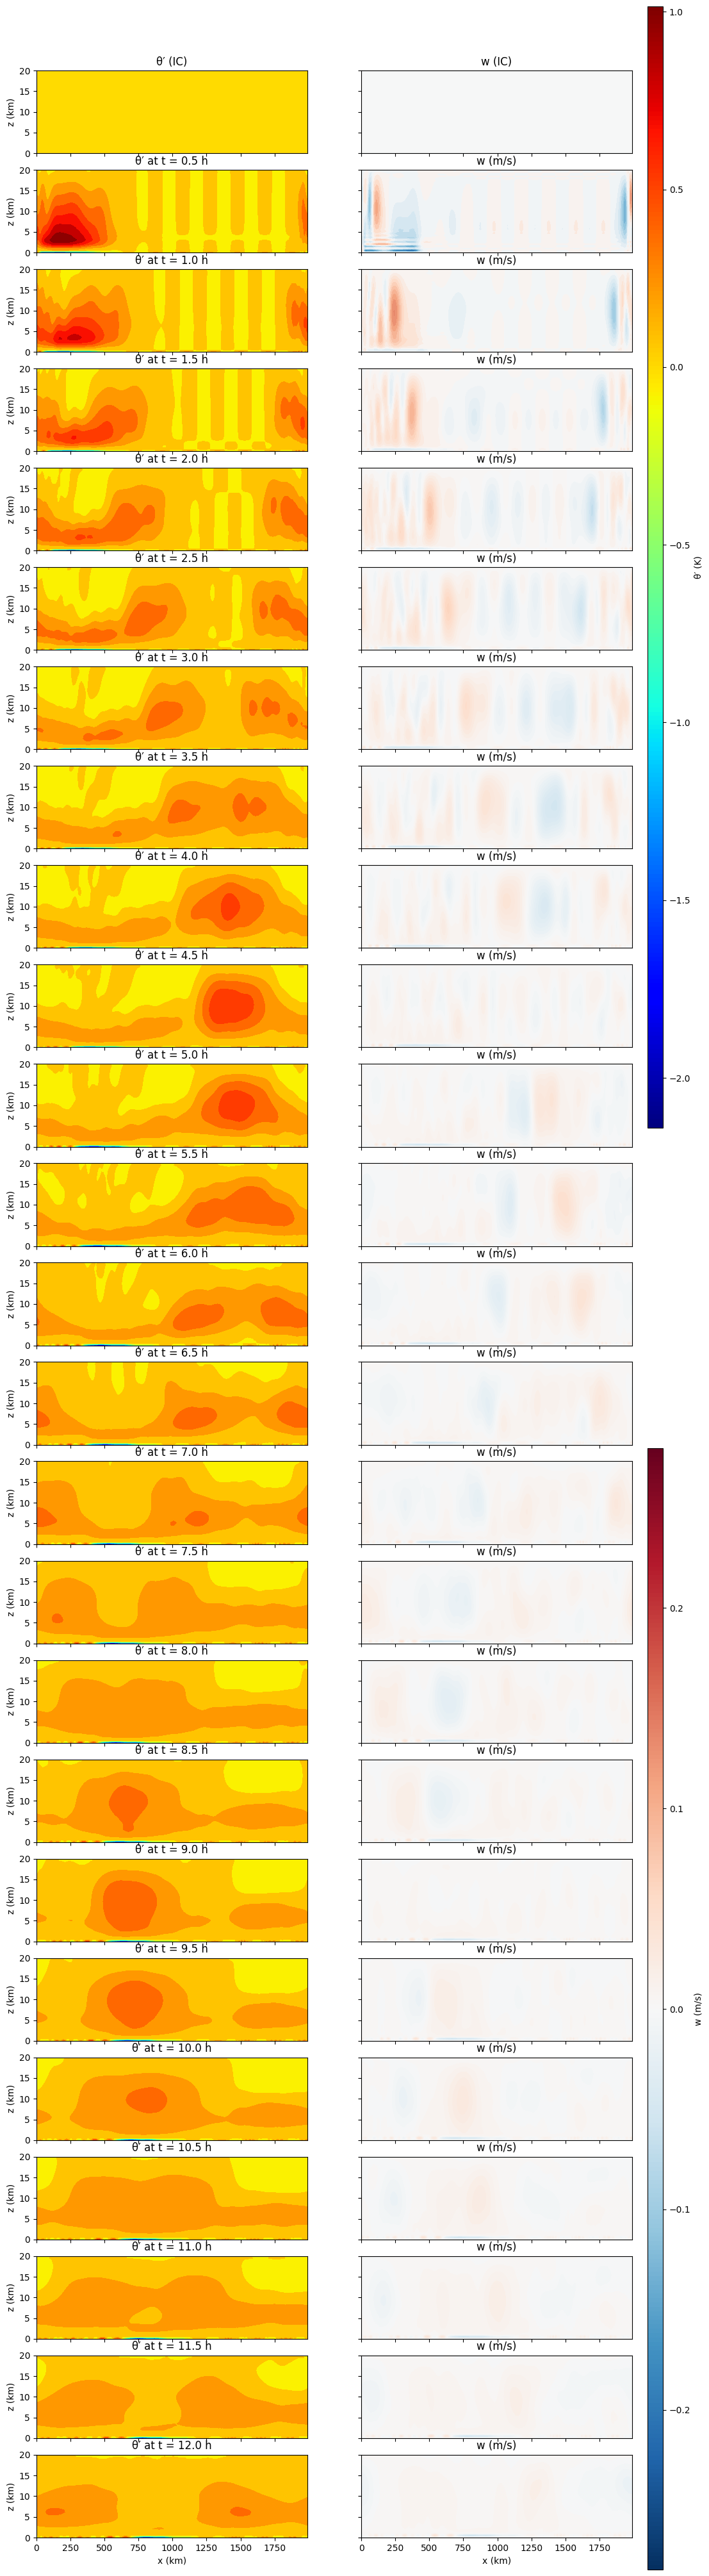

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# ============================================================
# Synoptic visualization: IC + hourly snapshots
# ============================================================

X_km = X / 1e3
Z_km = Z / 1e3

# ------------------------------------------------------------
# Prepend initial condition (hour 0)
# ------------------------------------------------------------
plot_th = [theta0] + snap_th
plot_w  = [np.zeros_like(snap_w[0])] + snap_w
plot_t  = [0.0] + snap_t   # seconds

nrows = len(plot_t)

# ------------------------------------------------------------
# Global limits (robust, physically meaningful)
# ------------------------------------------------------------
thp_all = np.concatenate([(th - theta0).ravel() for th in plot_th])
w_all   = np.concatenate([w.ravel() for w in plot_w])

thp_min, thp_max = thp_all.min(), thp_all.max()
w_max = np.max(np.abs(w_all))

norm_th = Normalize(vmin=thp_min, vmax=thp_max)
norm_w  = Normalize(vmin=-w_max, vmax=w_max)

# ------------------------------------------------------------
# Figure
# ------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=2,
    figsize=(12, 2.0 * nrows),
    sharex=True,
    sharey=True
)

for i, (th, w, tsec) in enumerate(zip(plot_th, plot_w, plot_t)):
    thp = th - theta0
    hour = tsec / 3600.0

    # θ′ (left)
    ax = axes[i, 0]
    ax.contourf(
        X_km, Z_km, thp,
        levels=21,
        cmap="jet",
        norm=norm_th
    )
    ax.set_ylabel("z (km)")
    ax.set_title("θ′ (IC)" if hour == 0 else f"θ′ at t = {hour:.1f} h")

    # w (right)
    ax = axes[i, 1]
    ax.contourf(
        X_km, Z_km, w,
        levels=21,
        cmap="RdBu_r",
        norm=norm_w
    )
    ax.set_title("w (IC)" if hour == 0 else "w (m/s)")

axes[-1, 0].set_xlabel("x (km)")
axes[-1, 1].set_xlabel("x (km)")

# ------------------------------------------------------------
# Colorbars (explicit ScalarMappables)
# ------------------------------------------------------------
sm_th = ScalarMappable(norm=norm_th, cmap="jet")
sm_th.set_array([])

sm_w = ScalarMappable(norm=norm_w, cmap="RdBu_r")
sm_w.set_array([])

# θ′ colorbar (top)
cax_th = fig.add_axes([0.92, 0.55, 0.02, 0.35])
cb_th = fig.colorbar(sm_th, cax=cax_th)
cb_th.set_label("θ′ (K)")

# w colorbar (bottom)
cax_w = fig.add_axes([0.92, 0.10, 0.02, 0.35])
cb_w = fig.colorbar(sm_w, cax=cax_w)
cb_w.set_label("w (m/s)")

plt.savefig("atm_front_evolution.png")
plt.show()


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import os

# ============================================================
# Save one figure per snapshot (IC + hourly)
# ============================================================

os.makedirs(".", exist_ok=True)

X_km = X / 1e3
Z_km = Z / 1e3

# ------------------------------------------------------------
# Prepend IC
# ------------------------------------------------------------
plot_th = [theta0] + snap_th
plot_w  = [np.zeros_like(snap_w[0])] + snap_w
plot_t  = [0.0] + snap_t

# ------------------------------------------------------------
# Global limits (fixed across all frames)
# ------------------------------------------------------------
thp_all = np.concatenate([(th - theta0).ravel() for th in plot_th])
w_all   = np.concatenate([w.ravel() for w in plot_w])

thp_min, thp_max = thp_all.min(), thp_all.max()
w_max = np.max(np.abs(w_all))

norm_th = Normalize(vmin=thp_min, vmax=thp_max)
norm_w  = Normalize(vmin=-w_max, vmax=w_max)

sm_th = ScalarMappable(norm=norm_th, cmap="jet")
sm_th.set_array([])

sm_w = ScalarMappable(norm=norm_w, cmap="RdBu_r")
sm_w.set_array([])

# ------------------------------------------------------------
# Loop over times and save figures
# ------------------------------------------------------------
for i, (th, w, tsec) in enumerate(zip(plot_th, plot_w, plot_t)):
    hour = tsec / 3600.0
    thp = th - theta0

    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(11, 4),
        sharex=True,
        sharey=True
    )

    # θ′
    cf_th = axes[0].contourf(
        X_km, Z_km, thp,
        levels=21,
        cmap="jet",
        norm=norm_th
    )
    axes[0].set_title("θ′ (IC)" if hour == 0 else f"θ′ at t = {hour:.1f} h")
    axes[0].set_xlabel("x (km)")
    axes[0].set_ylabel("z (km)")

    # w
    cf_w = axes[1].contourf(
        X_km, Z_km, w,
        levels=21,
        cmap="RdBu_r",
        norm=norm_w
    )
    axes[1].set_title("w (IC)" if hour == 0 else "w (m/s)")
    axes[1].set_xlabel("x (km)")

    # Colorbars (fixed placement)
    cax_th = fig.add_axes([0.92, 0.55, 0.02, 0.35])
    cb_th = fig.colorbar(sm_th, cax=cax_th)
    cb_th.set_label("θ′ (K)")

    cax_w = fig.add_axes([0.92, 0.10, 0.02, 0.35])
    cb_w = fig.colorbar(sm_w, cax=cax_w)
    cb_w.set_label("w (m/s)")

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    fname = f"atm_cold_pool_{i:02d}.png"
    plt.savefig(fname, dpi=150)
    plt.close(fig)

    print(f"saved {fname}")

print("✔ All frames written.")


/tmp/ipykernel_21345/1482619478.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


saved atm_cold_pool_00.png
saved atm_cold_pool_01.png
saved atm_cold_pool_02.png
saved atm_cold_pool_03.png
saved atm_cold_pool_04.png
saved atm_cold_pool_05.png
saved atm_cold_pool_06.png
saved atm_cold_pool_07.png
saved atm_cold_pool_08.png
saved atm_cold_pool_09.png
saved atm_cold_pool_10.png
saved atm_cold_pool_11.png
saved atm_cold_pool_12.png
saved atm_cold_pool_13.png
saved atm_cold_pool_14.png
saved atm_cold_pool_15.png
saved atm_cold_pool_16.png
saved atm_cold_pool_17.png
saved atm_cold_pool_18.png
saved atm_cold_pool_19.png
saved atm_cold_pool_20.png
saved atm_cold_pool_21.png
saved atm_cold_pool_22.png
saved atm_cold_pool_23.png
saved atm_cold_pool_24.png
✔ All frames written.


In [18]:
np.savez(
    "atm_state_and_history.npz",
    u=u,
    w=w,
    theta=theta,
    theta0=theta0,
    snap_u=np.array(snap_u),
    snap_w=np.array(snap_w),
    snap_th=np.array(snap_th),
    snap_t=np.array(snap_t),
    X=X,
    Z=Z
)

print("State and history saved.")

State and history saved.


In [19]:
print([t/3600 for t in snap_t])

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0]
